In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import time

df=pd.read_csv('DailyReturn.csv')
date_num=df.shape[0]
weight=np.zeros(date_num)
asset_num=df.shape[1]-1

lamda_set=np.arange(0.1,1,0.1) #from 0.1 to 0.9 
lamda_num=len(lamda_set)
CV_mat=np.zeros([lamda_num,asset_num])
for k in range(lamda_num):
    print(k)
    lamda = lamda_set[k]
    for i in range(date_num):
        weight[i] = (1 - lamda) * lamda ** (60 - i - 1)
    weight = weight / np.sum(weight)

    mat = np.zeros([asset_num, asset_num])
    for i in range(asset_num):
        for j in range(asset_num):
            temp = df.iloc[:, i + 1]
            temp_2 = df.iloc[:, j + 1]
            if i == j:
                mat[i, i] = np.sum(weight * (temp - np.mean(temp)) ** 2)
            else:
                mat[i, j] = np.sum(weight * (temp - np.mean(temp)) * (temp_2 - np.mean(temp_2)))

    eigval, eigvec = np.linalg.eig(mat)
    eigval = -np.sort(-np.real(eigval))
    cumulative_variance = np.cumsum(np.real(eigval / np.sum(eigval)))
    CV_mat[k,:]=cumulative_variance


0
1
2
3
4
5
6
7
8


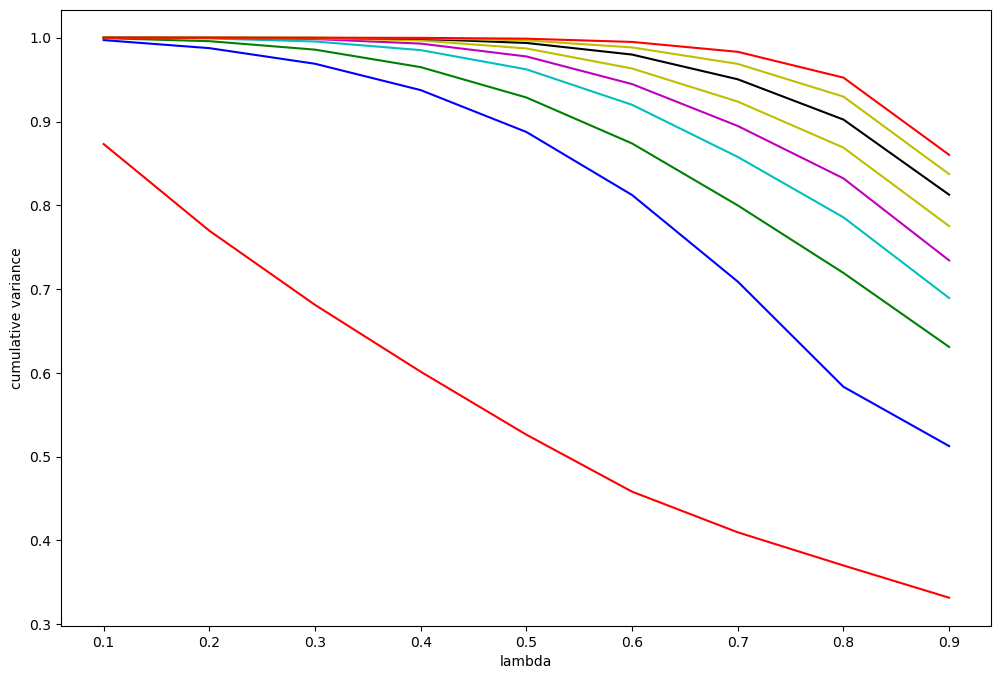

In [48]:
plt.figure(figsize=(12, 8))
plt.plot(lamda_set,CV_mat[:,0],'r-')
plt.plot(lamda_set,CV_mat[:,1],'b-')
plt.plot(lamda_set,CV_mat[:,2],'g-')
plt.plot(lamda_set,CV_mat[:,3],'c-')
plt.plot(lamda_set,CV_mat[:,4],'m-')
plt.plot(lamda_set,CV_mat[:,5],'y-')
plt.plot(lamda_set,CV_mat[:,6],'k-')
plt.plot(lamda_set,CV_mat[:,7],'y-')
plt.plot(lamda_set,CV_mat[:,8],'r-')
plt.xlabel('lambda')
plt.ylabel('cumulative variance')
plt.show()




In [53]:
cor_mat=df.iloc[:,1:].corr()
cov_mat=df.iloc[:,1:].cov()
lamda = 0.97  #set lamda = 0.97
for i in range(date_num):
    weight[i] = (1 - lamda) * lamda ** (60 - i - 1)
weight = weight / np.sum(weight) #calculate weight 

ew_cov_mat = np.zeros([asset_num, asset_num])
for i in range(asset_num):
    for j in range(asset_num):
        temp = df.iloc[:, i + 1]
        temp_2 = df.iloc[:, j + 1]
        if i == j:
            ew_cov_mat[i, i] = np.sum(weight * (temp - np.mean(temp)) ** 2)
        else:
            ew_cov_mat[i, j] = np.sum(weight * (temp - np.mean(temp)) * (temp_2 - np.mean(temp_2))) #exponentially weighted cov

ew_cor_mat= np.zeros([asset_num, asset_num])
for i in range(asset_num):
    for j in range(asset_num):
        if i == j:
            ew_cor_mat[i, i] = 1
        else:
            ew_cor_mat[i, j] = ew_cov_mat[i,j]/(np.sqrt(ew_cov_mat[i,i])*np.sqrt(ew_cov_mat[j,j])) #exponentially weighted cor

mat_set=[[cor_mat,cov_mat],[cor_mat,ew_cov_mat],[ew_cor_mat,cov_mat],[ew_cor_mat,ew_cov_mat]]
num=len(mat_set)
sim_num=25000
mat_rs=np.zeros([4,4])
mat_time=np.zeros([4,4])

for i in range(num):
    cor_mat_temp=mat_set[i][0]
    cov_mat_temp=mat_set[i][1]
    sigma=np.sqrt(np.diag(cov_mat_temp))

    #Direct Simulation
    start=time.time()
    eigval, eigvec = np.linalg.eig(cor_mat_temp)
    pos=np.where(np.real(eigval)<=0)[0]
    eigval[pos]=0
    B=np.dot(eigvec,np.diag(eigval))
    Z=np.random.randn(asset_num,sim_num)
    X=np.dot(B,Z).transpose()
    X=np.multiply(X,sigma)
    cov_mat_3=np.matrix(pd.DataFrame(X).cov())
    mat_rs[i,0]=np.sqrt(np.sum(np.sum((cov_mat_3-cov_mat_temp)**2)))
    #mat_rs[i,0]=np.linalg.norm((cov_mat_3-cov_mat_temp),'fro')
    end=time.time()
    mat_time[i,0]=end-start

    #PCA with 100% explained
    start=time.time()
    eigval, eigvec = np.linalg.eig(cor_mat_temp)
    pos=np.where(np.real(eigval)>0)[0]
    B=np.dot(eigvec[:,pos],np.diag(eigval[pos]))
    Z=np.random.randn(len(pos),sim_num)
    X=np.dot(B,Z).transpose()
    X=np.multiply(X,sigma)
    cov_mat_3=np.matrix(pd.DataFrame(X).cov())
    mat_rs[i,1]=np.sqrt(np.sum(np.sum((cov_mat_3-cov_mat_temp)**2)))
    #mat_rs[i,1]=np.linalg.norm((cov_mat_3-cov_mat_temp),'fro')
    end=time.time()
    mat_time[i,1]=end-start

    #PCA with 75% explained
    start=time.time()
    eigval_2=np.real(eigval[pos])
    cumulative_variance=np.cumsum(eigval_2/np.sum(eigval_2))
    pos_2=np.where(cumulative_variance>=0.75)[0][0]
    pos_2=np.arange(pos_2+1)
    B=np.dot(eigvec[:,pos_2],np.diag(eigval[pos_2]))
    Z=np.random.randn(len(pos_2),sim_num)
    X=np.dot(B,Z).transpose()
    X=np.multiply(X,sigma)
    cov_mat_3=np.matrix(pd.DataFrame(X).cov())
    mat_rs[i,2]=np.sqrt(np.sum(np.sum((cov_mat_3-cov_mat_temp)**2)))
    #mat_rs[i,2]=np.linalg.norm((cov_mat_3-cov_mat_temp),'fro')
    end=time.time()
    mat_time[i,2]=end-start

    #PCA with 50% explained
    start=time.time()
    eigval_2=np.real(eigval[pos])
    cumulative_variance=np.cumsum(eigval_2/np.sum(eigval_2))
    pos_2=np.where(cumulative_variance>=0.5)[0][0]
    pos_2=np.arange(pos_2+1)
    B=np.dot(eigvec[:,pos_2],np.diag(eigval[pos_2]))
    Z=np.random.randn(len(pos_2),sim_num)
    X=np.dot(B,Z).transpose()
    X=np.multiply(X,sigma)
    cov_mat_3=np.matrix(pd.DataFrame(X).cov())
    mat_rs[i,3]=np.sqrt(np.sum(np.sum((cov_mat_3-cov_mat_temp)**2)))
    #mat_rs[i,3]=np.linalg.norm((cov_mat_3-cov_mat_temp),'fro')
    end=time.time()
    mat_time[i,3]=end-start
    
print('Duration: \n', mat_time)
print('F Norm: \n',mat_rs)


Duration: 
 [[0.13661909 0.11063385 0.03633094 0.02352214]
 [0.12929606 0.10980701 0.03465104 0.02375984]
 [0.13182735 0.10598779 0.03252602 0.02395701]
 [0.13148713 0.10826397 0.03299522 0.02417994]]
F Norm: 
 [[0.24491091 0.24964341 0.24525897 0.24809821]
 [2.04725499 2.05333715 2.04457129 2.07061557]
 [0.28044553 0.2758313  0.27877684 0.27796642]
 [2.19437985 2.20318733 2.22906652 2.20849344]]
